In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter as dfmt
from datetime import datetime
import struct 

In [21]:
f = open('TaurusScanMarch10.bin','rb')
s=f.read()
f.close()
numFloats=len(s)/4 
bins=256
floatsPerRow = bins
numRows=numFloats/floatsPerRow

rows = []
for j in range(int(numRows)):
    rows.append(struct.unpack(("%if" % floatsPerRow),
    			s[j*floatsPerRow*4:(j+1)*floatsPerRow*4]))

data = np.array(rows)
len(data)

4188

In [22]:
len(s)

4288512

In [23]:
dE = []
dt = []
def METDATA(x,y,z):
    def getMeta():
        f=open(x + '.met','r')
        mets=f.readlines()
        f.close()
        metDict = {}
        for met in mets:
            val, key = [x.strip() for x in met.split("#")]
            if 'UTC' in val:
                metDict[key] = datetime.strptime(val, "%Y-%m-%d %H:%M:%S %Z")
            elif '.' in val:
                metDict[key] = float(val)
            else:
                metDict[key] = int(val)

        return metDict

    def getRadioData(file):

        f = open(file + '.bin','rb')
        s=f.read()
        f.close()
        numFloats=len(s)/4 
        bins=256
        floatsPerRow = bins
        numRows=numFloats/floatsPerRow

        rows = []
        for j in range(int(numRows)):
            rows.append(struct.unpack(("%if" % floatsPerRow),
                        s[j*floatsPerRow*4:(j+1)*floatsPerRow*4]))

        return np.array(rows)

    def buildDataFrame(file='', metDict=None, radioData=None):
        if metDict is None:
            if not file:
                raise RuntimeError("Ack. Without metadata, I need a file!")
            else:
                metDict = getMeta()
        if radioData is None:
            if not file:
                raise RuntimeError("Ack. Without radio data, I need a file!")
            else:
                radioData = getRadioData(file)

        startTime= metDict['firstAcqTimestamp UTC'].timestamp()
        endTime= metDict['lastAcqTimestamp UTC'].timestamp()
        times= np.linspace(startTime, endTime, len(radioData))
        tstamps= np.array([datetime.fromtimestamp(x) 
                  for x in times])
        tseries= pd.Series(tstamps)
        return pd.DataFrame({'time':tseries, 'energy':radioData.mean(axis=1)})
    df = buildDataFrame(x)
    #df.plot('time','energy',figsize=(14,10))
    #plt.ylabel('Radio Energy (dB)')
    #plt.grid()
    begin = y
    end = z

    fig = plt.figure(figsize=(14,10))
    ax = plt.gca()

    form_date = dfmt('%m/%d %H:%M')
    ax.xaxis.set_major_formatter(form_date)

    plt.xlabel('time (m-d h, UTC)')
    plt.ylabel('Relative Energy (dB)')
    plt.title('A recent glimps of Taurus A')
    plt.grid()
    plt.plot(df.time[begin:end], df.energy[begin:end],'b.')
    dE.append([df.energy[begin:end]])
    dt.append([df.time[begin:end]])
    begin = 0
    end = 4193
    fig = plt.figure(figsize=(14,10))
    ax = plt.gca()

    form_date = dfmt('%m/%d %H:%M')
    ax.xaxis.set_major_formatter(form_date)

    plt.xlabel('time (m-d h, UTC)')
    plt.ylabel('Relative Energy (dB)')
    plt.title('A recent glimps of Taurus A')
    plt.grid()
    plt.plot(df.time[begin:], df.energy[begin:],'b.')
    

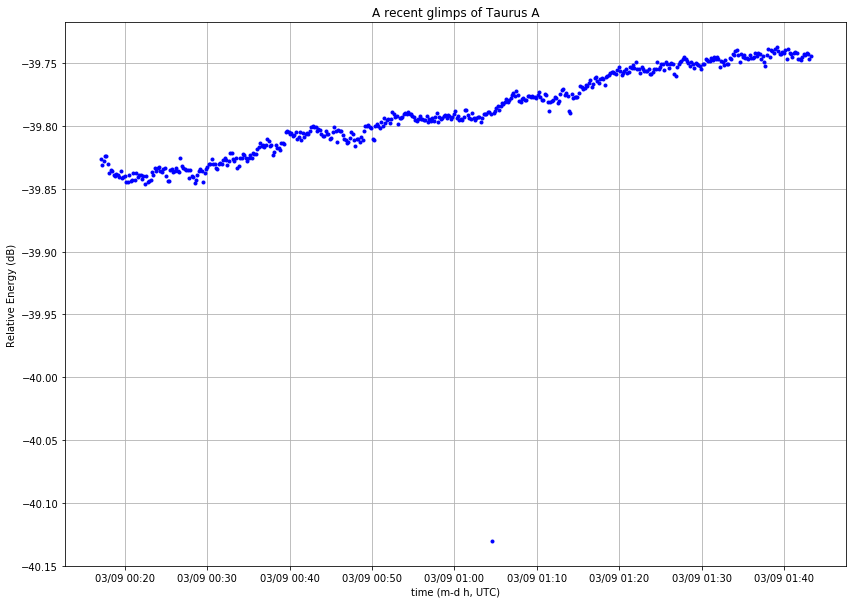

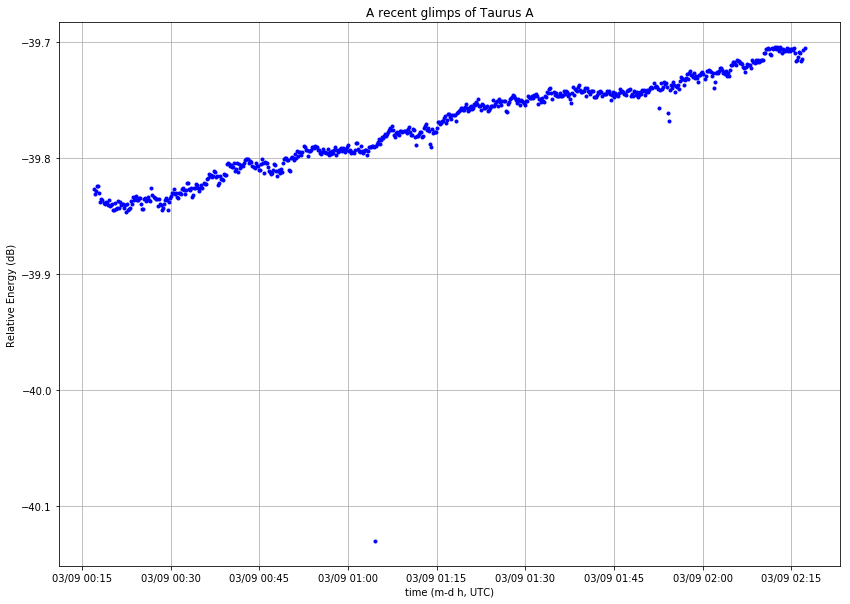

In [106]:
METDATA('TaurusScanMarch09',0,500)

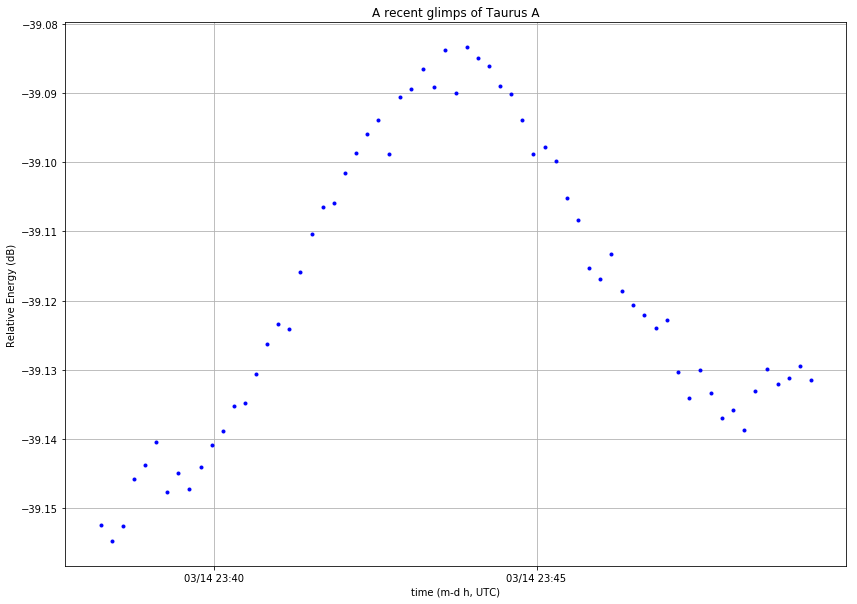

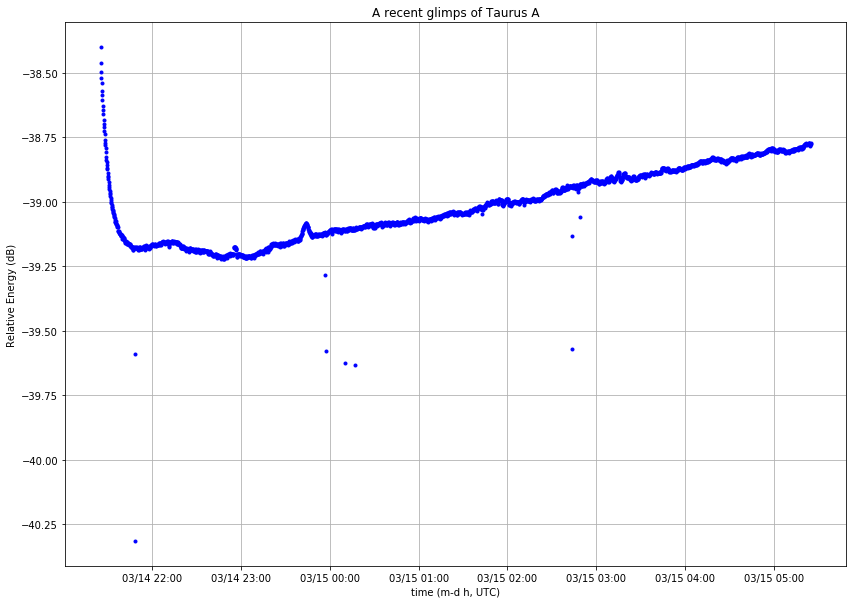

In [24]:
METDATA('TaurusScanMarch14',775,840)

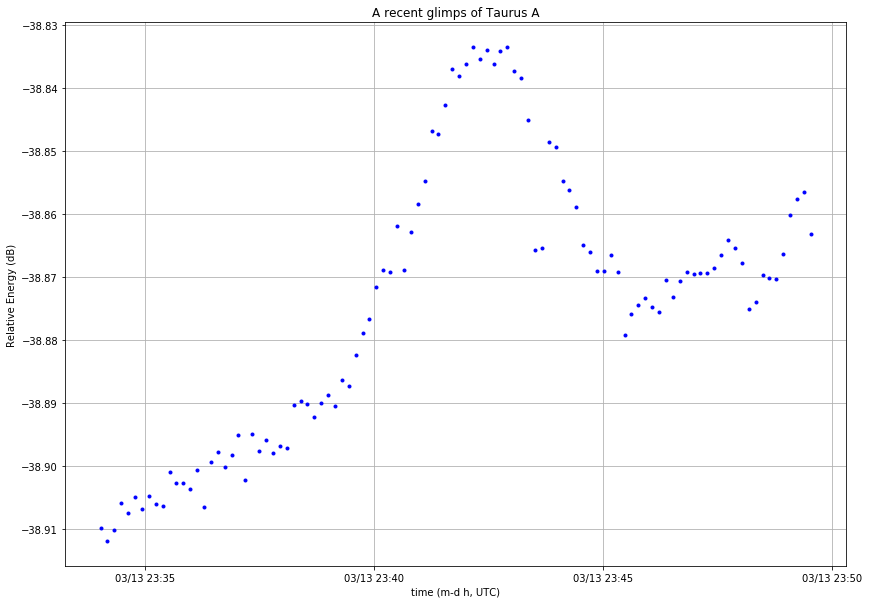

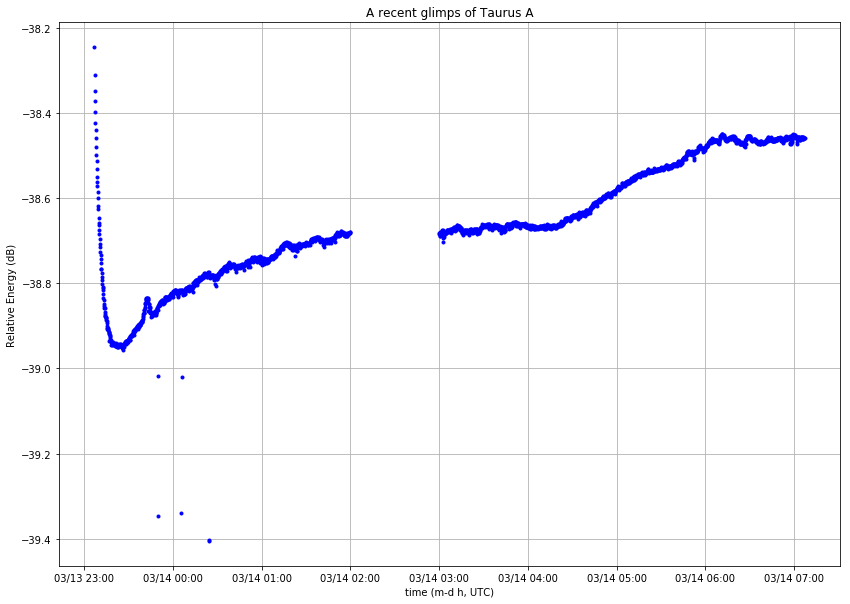

In [67]:
METDATA('TaurusScanMarch13',180,284)

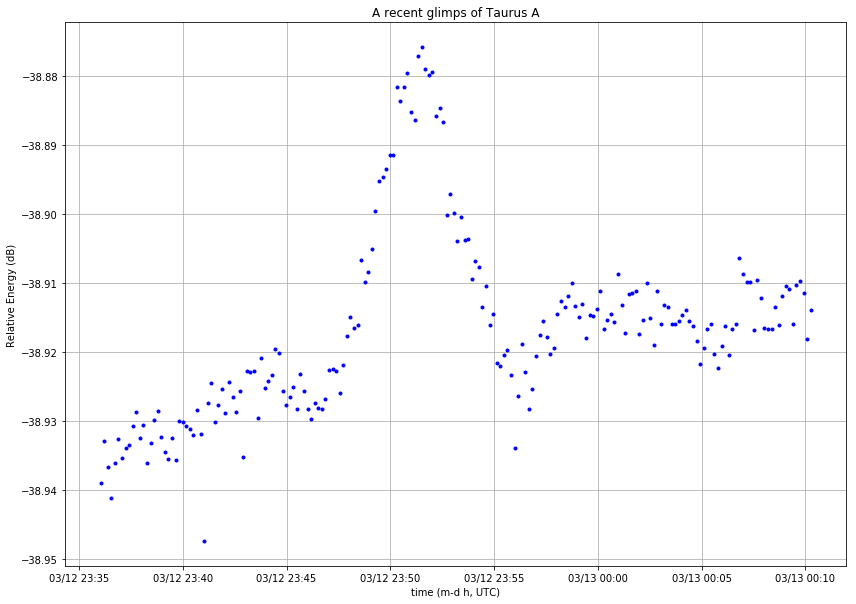

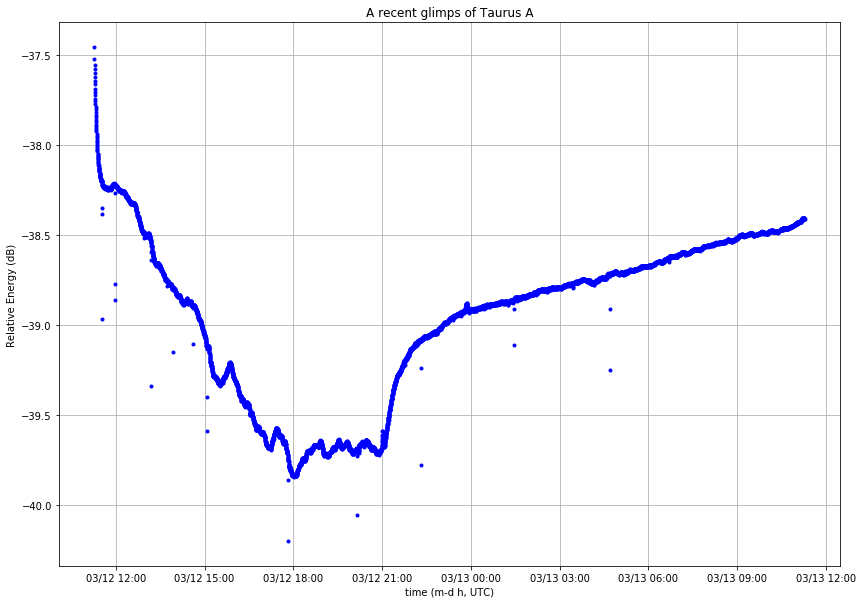

In [82]:
METDATA('TaurusScanMarch12',4300,4500)

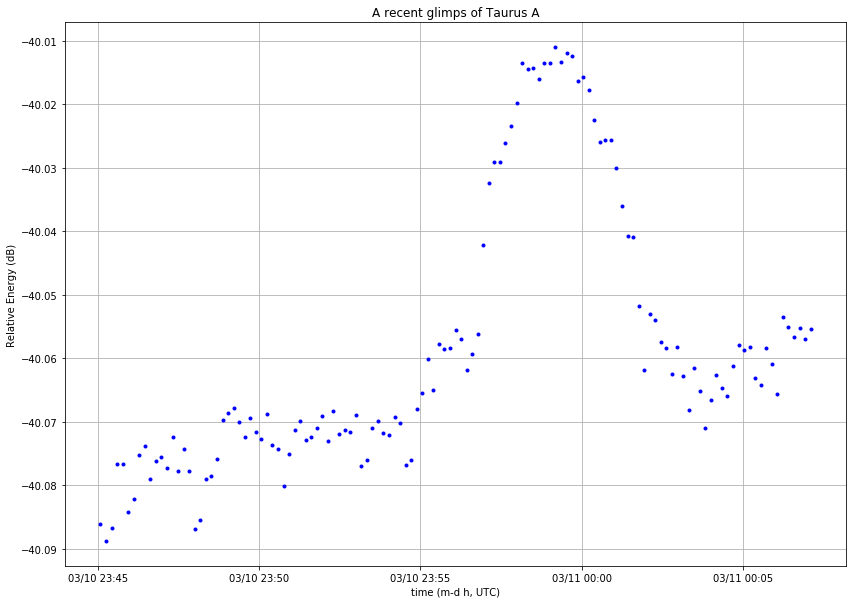

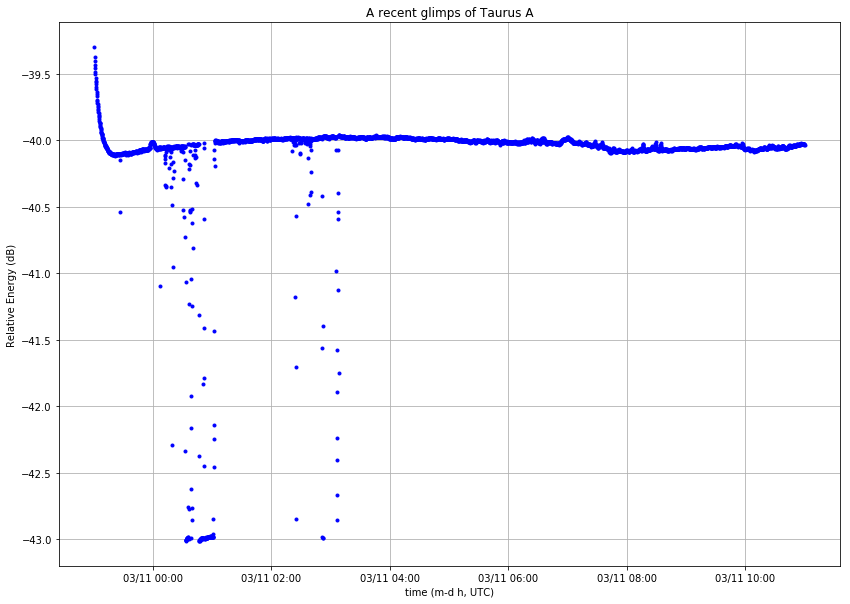

In [95]:
METDATA('TaurusScanMarch11',260,389)

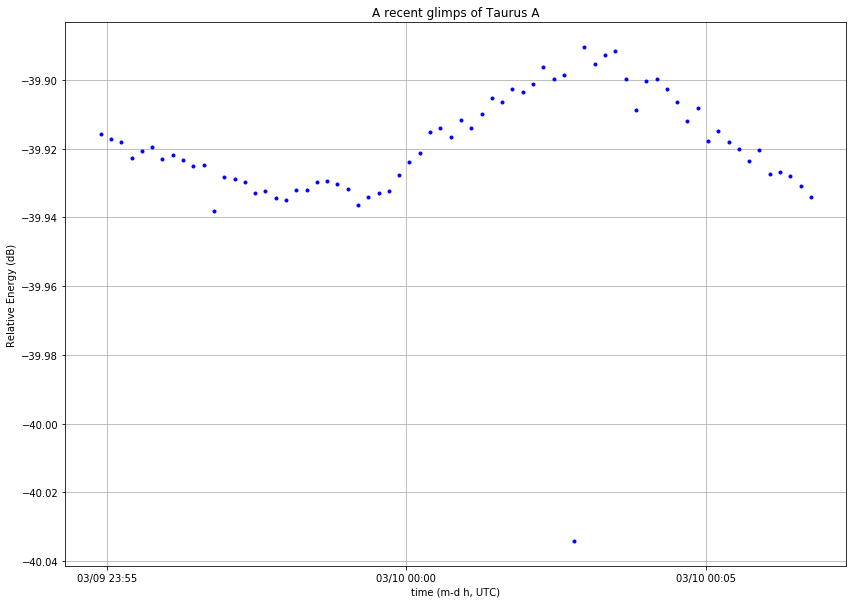

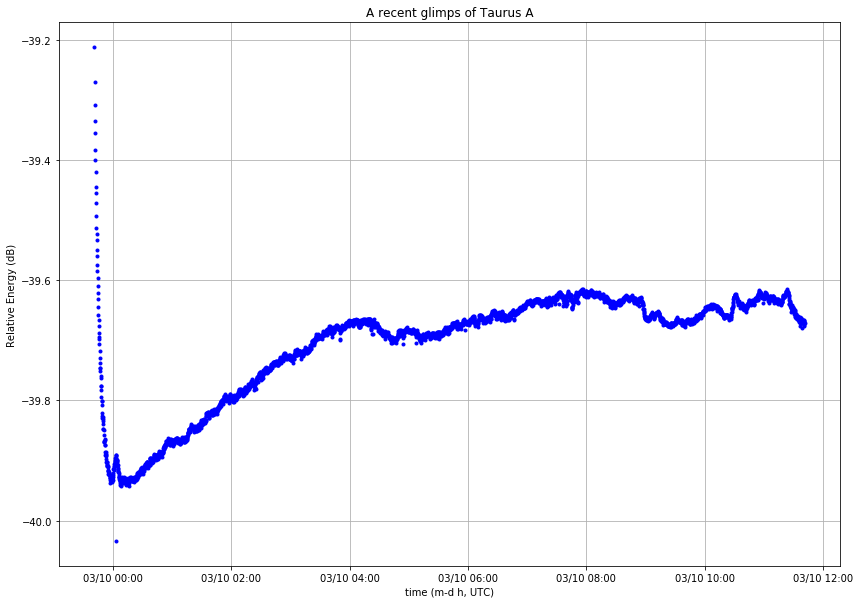

In [101]:
METDATA('TaurusScanMarch10',80,150) ## MISSED IT! ERROR!!!

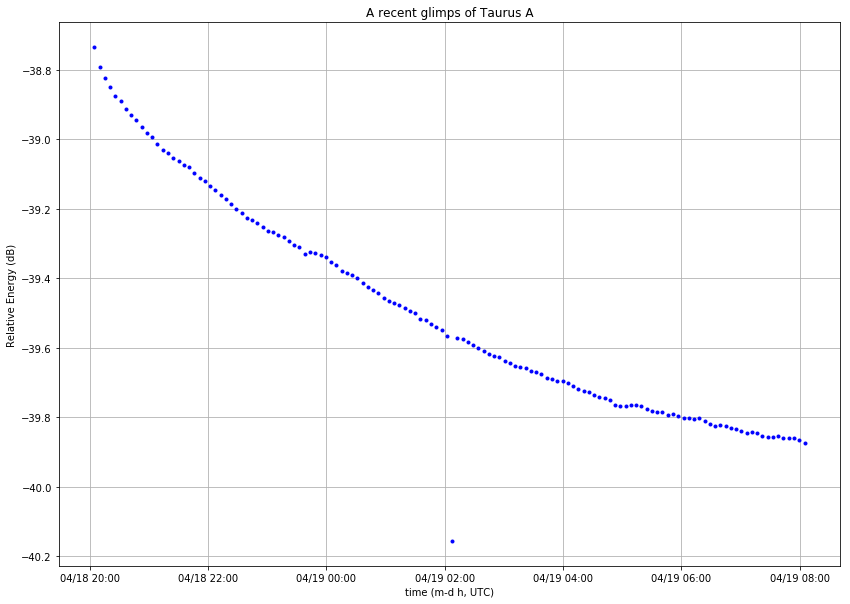

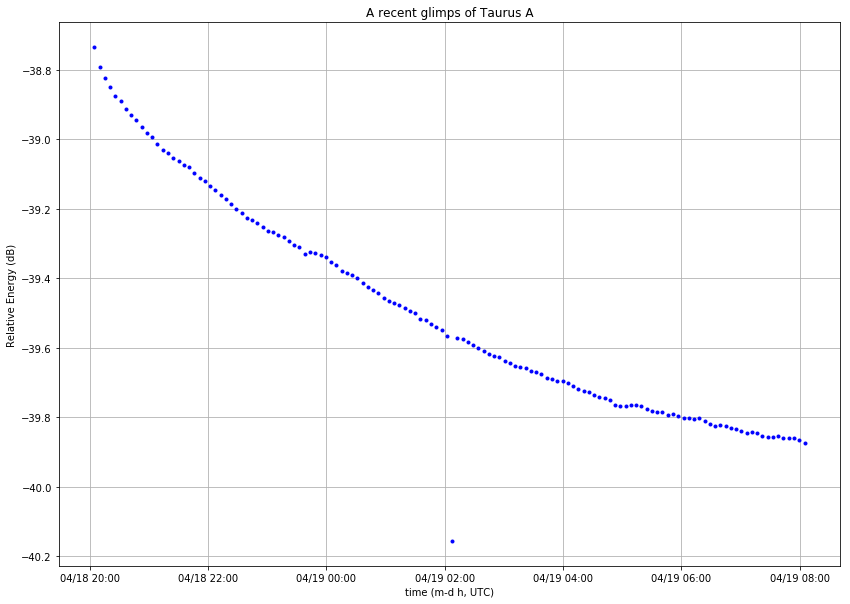

In [29]:
METDATA('TaurusScan04182021',0,5000)

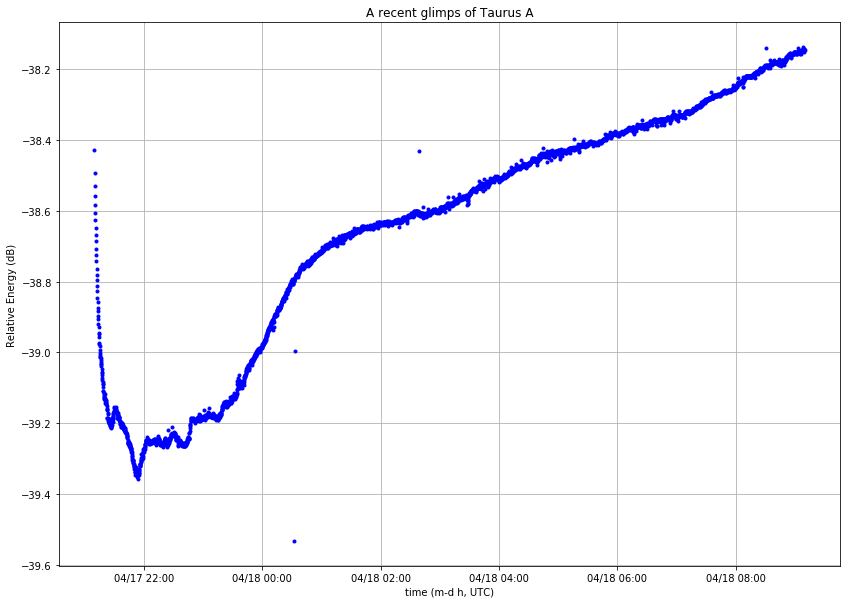

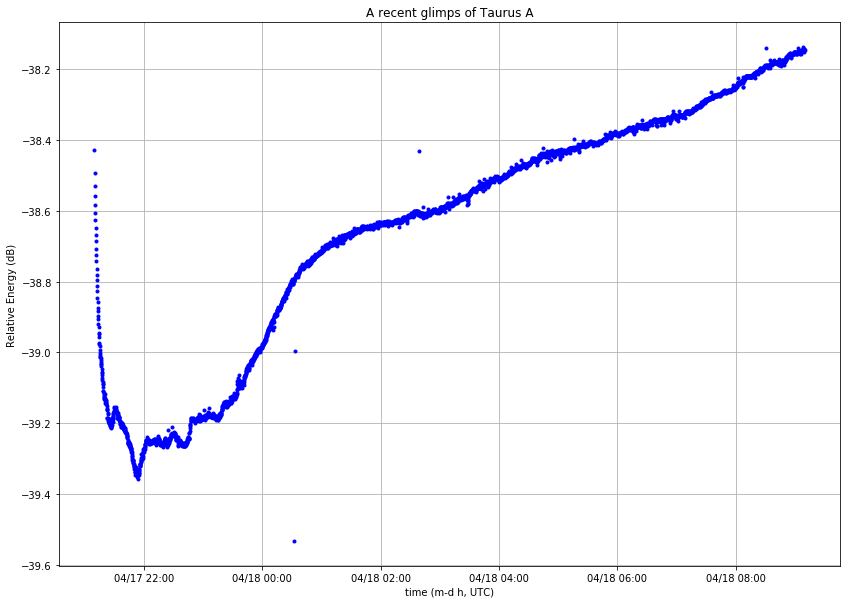

In [30]:
METDATA('TaurusScan04172021',0,5000)

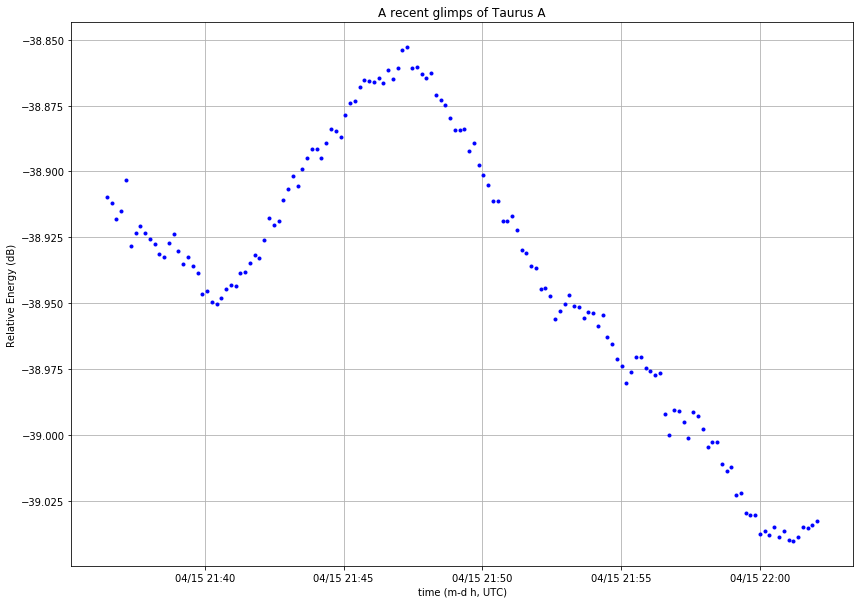

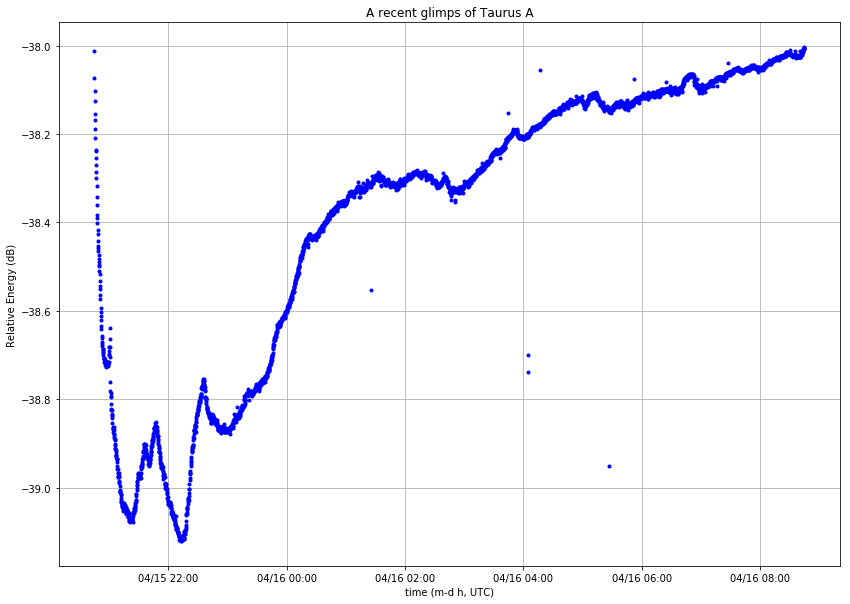

In [103]:
METDATA('TaurusScan04152021',300,450)

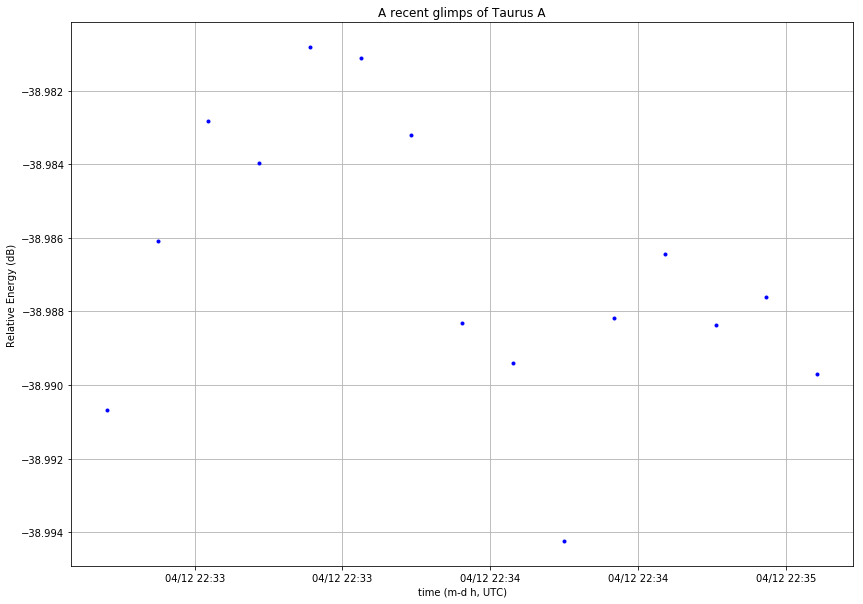

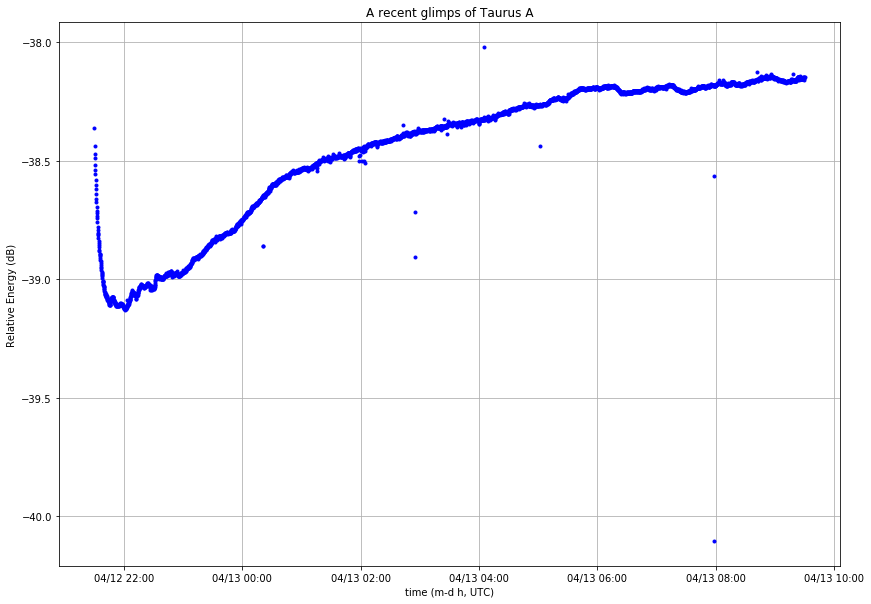

In [32]:
METDATA('TaurusScan04122021',365,380)

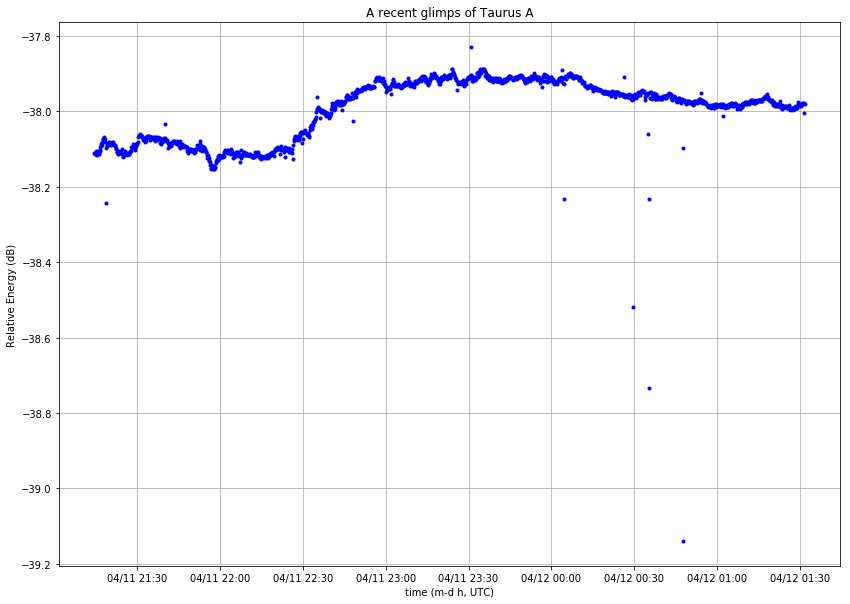

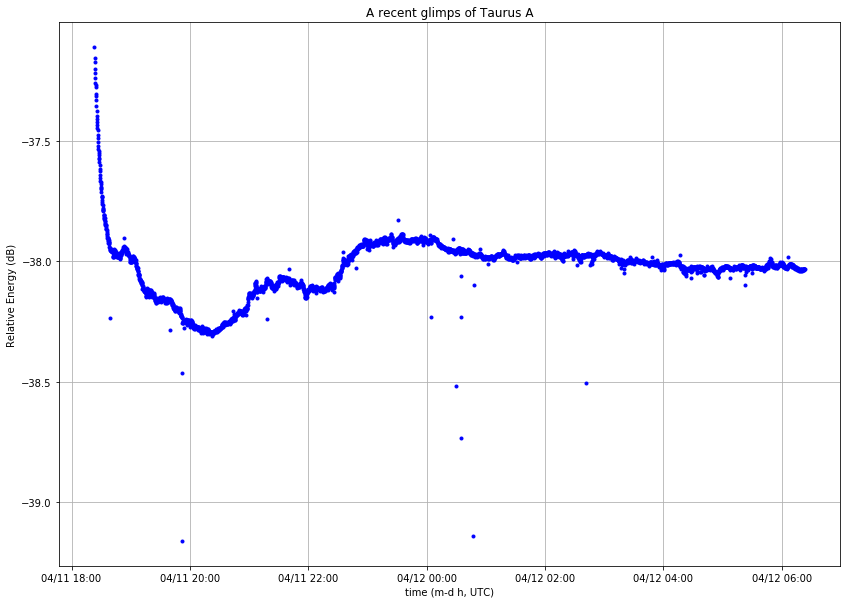

In [33]:
METDATA('TaurusScan04112021',1000,2500)

In [34]:
dEnergies = np.array(dE)

In [35]:
dE

[[775   -39.152431
  776   -39.154762
  777   -39.152601
  778   -39.145746
  779   -39.143826
  780   -39.140411
  781   -39.147641
  782   -39.144927
  783   -39.147177
  784   -39.144013
  785   -39.140898
  786   -39.138833
  787   -39.135208
  788   -39.134754
  789   -39.130565
  790   -39.126245
  791   -39.123431
  792   -39.124057
  793   -39.115796
  794   -39.110404
  795   -39.106425
  796   -39.105857
  797   -39.101532
  798   -39.098640
  799   -39.095899
  800   -39.093865
  801   -39.098754
  802   -39.090544
  803   -39.089418
  804   -39.086438
           ...    
  810   -39.086121
  811   -39.088948
  812   -39.090102
  813   -39.093954
  814   -39.098734
  815   -39.097788
  816   -39.099759
  817   -39.105225
  818   -39.108349
  819   -39.115341
  820   -39.116802
  821   -39.113284
  822   -39.118584
  823   -39.120657
  824   -39.122036
  825   -39.124004
  826   -39.122819
  827   -39.130363
  828   -39.134072
  829   -39.130047
  830   -39.133408
  831   -39.

In [46]:
from scipy.optimize import curve_fit
from scipy.misc import derivative
from math import *


def objective(x,x0,w,S,m,b):
        return  m*(x-x0) + b + S*np.exp(-((x-x0)/w)**2)
#        return a*np.sin(n*x+phi)
def curve_fitting(xvals,yvals):
    x0_0=22
    w_0= 300
    S_0= -38.37
    m_0= -0.015
    b_0=-39.25 
    popt, pcov = curve_fit(objective, xvals, yvals,p0=(x0_0, w_0, S_0, m_0, b_0))
    x0, w, S, m, b = popt
#    a,n,phi = popt
    plt.plot(xvals,yvals,'b*')
    plt.plot(xvals,objective(xvals, x0,w,S,m,b),'r-')
    print(popt)
#    plt.plot(xvals,objective(xvals, a,n,phi),'r-')
 
    plt.grid()
#plt.yticks(np.arange(-2, 10, 3))
    plt.grid(color='k',linestyle =':',linewidth='0.5')
#    print("slope=", ma, "+/-", dm )
 #   print("intercept=", b, "+/-", db)


In [56]:
d1y = np.array(dE[0])
d2y = np.array(dE[1])
d3y = np.array(dE[2])
d4y = np.array(dE[3])
d5y = np.array(dE[4])
d1x = np.linspace(1,100,num = len(d1y[0]))
d2x = np.linspace(1,100,num = len(d2y[0]))
d3x = np.linspace(1,100,num = len(d3y[0]))
d4x = np.linspace(1,100,num = len(d4y[0]))
d5x = np.linspace(1,100,num = len(d5y[0]))

(d5y)

array([[-39.21198866, -39.2705602 , -39.30858938, -39.33450395,
        -39.35509335, -39.3839512 , -39.40032151, -39.42011727,
        -39.44450016, -39.45561829, -39.47101781, -39.49274525,
        -39.51395093, -39.52318636, -39.5334982 , -39.55070685,
        -39.56009611, -39.57477206, -39.58406739, -39.59607211,
        -39.61035645, -39.62173937, -39.63223176, -39.64502653,
        -39.65818292, -39.6659465 , -39.67697674, -39.68806285,
        -39.69531418, -39.69834113, -39.70615168, -39.71847239,
        -39.7298542 , -39.73819003, -39.74702719, -39.74702719,
        -39.75078996, -39.75985464, -39.76224269, -39.77643414,
        -39.77646786, -39.78267223, -39.79521333, -39.80038854,
        -39.8008239 , -39.80719921, -39.82079238, -39.82907723,
        -39.82626291, -39.82735278, -39.83074149, -39.83486025,
        -39.84009932, -39.84719944, -39.84805131, -39.84994987,
        -39.85762076, -39.86733484, -39.86880888, -39.86873895,
        -39.86482848, -39.86660081, -39.

In [48]:
y = np.array([-39.15243076, -39.15476163, -39.15260056, -39.14574587,
        -39.14382625, -39.1404106 , -39.14764106, -39.1449271 ,
        -39.14717717, -39.1440129 , -39.14089791, -39.13883281,
        -39.1352082 , -39.13475367, -39.13056484, -39.12624452,
        -39.12343061, -39.12405716, -39.11579618, -39.11040352,
        -39.10642526, -39.10585651, -39.10153158, -39.0986397 ,
        -39.09589912, -39.09386538, -39.09875356, -39.09054416,
        -39.08941831, -39.08643813, -39.08905856, -39.08373225,
        -39.08999713, -39.0833149 , -39.08489874, -39.08612122,
        -39.08894752, -39.09010208, -39.09395416, -39.0987345 ,
        -39.09778838, -39.09975898, -39.10522494, -39.10834938,
        -39.11534061, -39.11680235, -39.11328372, -39.11858428,
        -39.12065743, -39.12203559, -39.12400387, -39.12281908,
        -39.13036297, -39.13407175, -39.13004704, -39.133408  ,
        -39.13702488, -39.13581185, -39.13873339, -39.13299853,
        -39.12986077, -39.13203071, -39.13112648, -39.12944564,
        -39.13147436])
#x = lins
y2 = np.array([-40.0649486 , -40.05771881, -40.05859597, -40.0583847 ,
        -40.05557321, -40.05697033, -40.0619067 , -40.05925265,
        -40.05614699, -40.04223655, -40.03242737, -40.02914435,
        -40.02910978, -40.02617648, -40.02350606, -40.0198817 ,
        -40.0134626 , -40.01441659, -40.01433192, -40.01604012,
        -40.01347613, -40.01349106, -40.01098445, -40.01328558,
        -40.01199989, -40.01249133, -40.01642363, -40.01575539,
        -40.01769888, -40.02246211, -40.02592002, -40.02557139,
        -40.02565902, -40.03007539, -40.03606518, -40.04078341,
        -40.04094152, -40.05178136, -40.06183207, -40.0529943 ,
        -40.05395639, -40.05750041, -40.05834661, -40.06247239,
        -40.05819476, -40.062722  , -40.06807356, -40.06155916,
        -40.06508026, -40.07099427])
y3 = np.array([-38.92007227, -38.92552593, -38.9275995 , -38.92643586,
        -38.92495491, -38.92822622, -38.92309712, -38.92559117,
        -38.92821917, -38.92962186, -38.92738663, -38.92812386,
        -38.92826566, -38.92674588, -38.92251769, -38.92243111,
        -38.92271358, -38.92583273, -38.92185141, -38.91756891,
        -38.91489917, -38.91651805, -38.91606386, -38.90664031,
        -38.90984972, -38.90839775, -38.90501426, -38.89953771,
        -38.89521088, -38.89453447, -38.89339328, -38.89140803,
        -38.89135617, -38.88158843, -38.88364202, -38.88148275,
        -38.87949003, -38.8851169 , -38.88633613, -38.87709644,
        -38.87573807, -38.8789854 , -38.87985605, -38.87941949,
        -38.88576826, -38.88454798, -38.88665751, -38.90012217,
        -38.89703789, -38.8997411 , -38.90392436, -38.90039641,
        -38.9037064 , -38.9035358 , -38.90942124, -38.90679017,
        -38.90760109, -38.91335858, -38.91036594, -38.91603851,
        -38.91441108, -38.92158677, -38.92197894, -38.92035659,
        -38.91966741, -38.92328639, -38.93387716, -38.92628382,
        -38.91878009, -38.92290795, -38.92822661, -38.92536266,
        -38.92058183, -38.91750377, -38.91551845, -38.91777466,
        -38.92022452, -38.91931829, -38.91446331, -38.91260713])
y4 = np.array([-40.0649486 , -40.05771881, -40.05859597, -40.0583847 ,
        -40.05557321, -40.05697033, -40.0619067 , -40.05925265,
        -40.05614699, -40.04223655, -40.03242737, -40.02914435,
        -40.02910978, -40.02617648, -40.02350606, -40.0198817 ,
        -40.0134626 , -40.01441659, -40.01433192, -40.01604012,
        -40.01347613, -40.01349106, -40.01098445, -40.01328558,
        -40.01199989, -40.01249133, -40.01642363, -40.01575539,
        -40.01769888, -40.02246211, -40.02592002, -40.02557139,
        -40.02565902, -40.03007539, -40.03606518, -40.04078341,
        -40.04094152, -40.05178136, -40.06183207, -40.0529943 ,
        -40.05395639, -40.05750041, -40.05834661, -40.06247239,
        -40.05819476, -40.062722  , -40.06807356, -40.06155916,
        -40.06508026, -40.07099427])
y5 = np.array([-38.94639674, -38.94542372, -38.94954708, -38.95030726,
        -38.94818826, -38.94456623, -38.94303504, -38.94359599,
        -38.93861954, -38.93832602, -38.93457247, -38.93176179,
        -38.93293755, -38.92589544, -38.91766463, -38.9202942 ,
        -38.91895908, -38.91065222, -38.90672171, -38.90181188,
        -38.90557413, -38.89924952, -38.89490803, -38.89163244,
        -38.89131787, -38.89504653, -38.88929377, -38.88405481,
        -38.884812  , -38.88700059, -38.87842582, -38.87393121,
        -38.8732345 , -38.86795864, -38.86536887, -38.8655988 ,
        -38.86598079, -38.86458805, -38.86661553, -38.86141337,
        -38.8647294 , -38.86089249, -38.85408083, -38.85273787,
        -38.86065453, -38.86027724, -38.86292338, -38.86467898,
        -38.86282018, -38.87087554, -38.87299931, -38.87467666,
        -38.87967029, -38.88420466, -38.88407928, -38.88404597,
        -38.89237821, -38.88926096, -38.89752026, -38.90136954,
        -38.90501912, -38.91138019, -38.91111931, -38.91889788,
        -38.91879652, -38.91671596, -38.92215851, -38.92960632,
        -38.93092111, -38.93573007, -38.93660393, -38.94456978,
        -38.94435593, -38.94718039, -38.95588475, -38.9527882 ,
        -38.95031033, -38.94671166, -38.95113513, -38.95136167])

In [49]:
y[-1]

-39.13147436

[ 1.82458817e+01  8.79681200e+04 -4.07028520e+02 -1.42088090e-04
  3.66994027e+02]


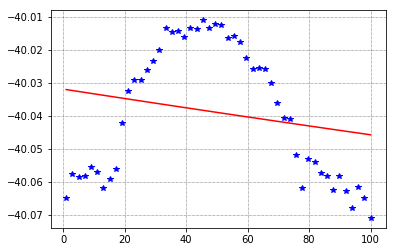

In [50]:
curve_fitting(d2x,y2)


In [51]:
curve_fitting(d3x,y3)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

[ 1.82458817e+01  8.79681200e+04 -4.07028520e+02 -1.42088090e-04
  3.66994027e+02]


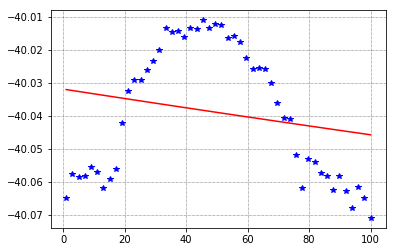

In [52]:
curve_fitting(d4x,y4)


In [53]:
curve_fitting(d5x,y5)


ValueError: operands could not be broadcast together with shapes (200,) (80,) 

TypeError: Improper input: N=5 must not exceed M=1

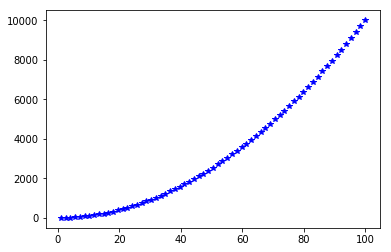

In [54]:
y = [i**2 for i in d1x ]
plt.plot(d1x,y,'b*')
curve_fitting(d1x,dE[0])

In [55]:
plt.plot(np.array(df5['Time (s)'])-0.5,np.array(df5['Velocity (m/s)'])*0.83,'b-', label = "Velocity by Phyphox")
plt.plot(df5['Time (s)'],np.array(df5['Velocity (m/s)']),'r-', label = "Velocity after integration")
plt.title("Error in fixed velocity")
plt.xlabel("Time (sec)")
plt.ylabel("Velocity (m/s)")
plt.legend(loc ="upper right")
plt.errorbar(np.array(df5['Time (s)'])-0.5, np.array(df5['Velocity (m/s)'])*0.83, yerr=np.array(df5['Velocity (m/s)'])-np.array(df5['Velocity (m/s)'])*0.83,lolims=True)
, yerr=yMc_error[0:11],lolims=True)


plt.grid(color='k',linestyle =':',linewidth='0.5')

NameError: name 'df5' is not defined